# Tutorial 10 – Hyper-parameters

In this tutorial we will take a look at hyper-parameters, how to tune them and Support Vector Machines.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()  # make plots nicer

## Hyper-parameters
Hyper-parameters are part of almost any model. Unlike parameters, hyper-parameters are not optimized during model training (calling `fit` method) instead they are fixed during training. Hyper-parameters are typically set during model construction by passing them as constructor parameters to models. We have used many hyper-parameters in previous tutorials, here are few examples.

* `DecisionTree`: `max_depth`, `criterion`
* `SimpleImputer`: `strategy`
* `KNNImputer`: `n_neighbors`
* `KNeighborsClassifier`: `n_neighbors`
* `Kmeans`: `n_clusters`
* `DBSCAN`: `eps`, `metric`

It is evident from the list above, that hyper-parameters are everywhere even in preprocessing.

Hyper-parameters can have profound impact on model performance. The model might by very sensitive to some hyper-parameter (e.g., produce very different result base on the actual value) and insensitive to others. For example, changing `criterion` in `DecisionTree` will produce similar results but changing `max_depth` will result in very different results. Also model can be more sensitive to changes in some range of value and in other. For example, changing `max_depth` form 2 to 3 is more radical than changing it from 20 to 25.

Unfortunately, there is no good way of knowing what hyper-parameters will be good in advance. It all depends on dataset, i.e. number of examples, number of features, feature distributions, separability, and other characteristics. You need to test different values and select the best performing one.

**NOTE:** Tuning hyper-parameters is one of the last steps when building a machine learning model. It does not make sense to play with hyper-parameters if you plan to, for example, extract additional features later because then you would need to tune the hyper-parameters again!

Let's load up a dataset with Pima indian diabates and play with hyper-parameters

In [2]:
diabetes = pd.read_csv("https://www.fi.muni.cz/~xcechak1/IB031/datasets/diabetes.csv")

diabetes.Glucose.replace(0, np.nan, inplace=True)
diabetes.BloodPressure.replace(0, np.nan, inplace=True)
diabetes.SkinThickness.replace(0, np.nan, inplace=True)
diabetes.Insulin.replace(0, np.nan, inplace=True)
diabetes.BMI.replace(0, np.nan, inplace=True)

diabetes.dropna(inplace=True)
diabetes.reset_index(drop=True, inplace=True)

diabetes.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            1     89.0           66.0           23.0     94.0  28.1   
1            0    137.0           40.0           35.0    168.0  43.1   
2            3     78.0           50.0           32.0     88.0  31.0   
3            2    197.0           70.0           45.0    543.0  30.5   
4            1    189.0           60.0           23.0    846.0  30.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.167   21        0  
1                     2.288   33        1  
2                     0.248   26        1  
3                     0.158   53        1  
4                     0.398   59        1

In [3]:
from sklearn.model_selection import train_test_split

diabetes_X, diabetes_y = diabetes.drop(columns="Outcome"), diabetes.Outcome

diabetes_train_X, diabetes_test_X, diabetes_train_y, diabetes_test_y = train_test_split(
    diabetes_X, diabetes_y, test_size=0.2, random_state=42
)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score


dtc = DecisionTreeClassifier()
dtc.fit(diabetes_train_X, diabetes_train_y)
print(f1_score(dtc.predict(diabetes_train_X), diabetes_train_y, average=None))
print(f1_score(dtc.predict(diabetes_test_X), diabetes_test_y, average=None))

[1. 1.]
[0.81553398 0.65454545]


<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

Try different combinations of hyper-parameters and observe the `DecisionTreeClassifier`'s performance. Look into [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to find what hyper-parameters and values are available. To which hyper-parameters is the model sensitive and to which insensitive. **Write your finding as a comment bellow.**

In [61]:
# TODO: your findings goes here...
#with hyper-parameter criterion='entropy' less sensitive and worse f1 score
#with hyper-parameter splitter='random' most of the time less sensitive and worse f1 score
#tried many different max_depth hyper-parameters, best seem to be the ones above 15
#min_samples_split in some cases also provided better results than default value 2 
#changing hyper-parameter min_samples_leaf to other value than default 1 didnt seem to provide better results
#max_features
dtc = DecisionTreeClassifier(max_features='sqrt')
dtc.fit(diabetes_train_X, diabetes_train_y)
print(f1_score(dtc.predict(diabetes_test_X), diabetes_test_y, average=None))

[0.79279279 0.5106383 ]


This is quite tedious process and the are a lot of combinations. This means two things:
1. It would be good to automatically go through all the combinations of hyper-parameters and select the best one.
2. It would be good if the best hyper-parameters were universally good and not best fit to data we have.

Luckily, both of them are covered by grid search with cross validation.

## Grid Search
Basic idea of grid search is very simple. It runs exhaustive search by training and evaluating the model with every possible combination of predefined hyper-parameter values. It is computational expensive as number of combinations grows exponentially with number of hyper-parameters explored. For example, say we would like to tune 5 different hyper-parameters each with 4 possible values. The grid search will have to train and evaluate $4^5$ models. That's a lot of models.

To reduce over-fitting the hyper-parameters are $k$-fold cross-validated. This assures that the selected hyper-parameters perform well across different portions of data and hopefully generalize well. The total number of models needed to be trained and evaluated is then $k$ times more.

Grid search is viable option only on small datasets, with simple models, or for few hyper-parameters. Say the training of the model takes around one second. Then the grid search from example above with 5-fold CV will take at least $4^5 \cdot 5$ seconds (~hour and a half).

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

Use [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with **10-fold** cross-validation to select best hyper-parameter for decision tree from Exercise 1. Use **F1** measure of positive class for optimization and finally evaluate the model with best hyper-parameters using **F1** on test set. Explore following hyper-parameter values in the grid search.
* maximal depth: 3, 5, 10, 20, 50
* minimal number of samples in leaf: 1, 3, 5, 7, 10
* feature selection criteria: Gini index, Info gain
* Cost-complexity pruning threshold: 0.0, 0.001, 0.01, 0.1, 0.3

Look into [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) or use `get_params` method to get hyper-parameter names.

The expected best hyper-parameters are 
`{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}`
and F1 score of positive class on test set is $0.655$

In [73]:
# TODO: your code goes here...
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[3, 5, 10, 20, 50], 'min_samples_leaf':[1, 3, 5, 7, 10], 'criterion':('gini', 'entropy'), 'ccp_alpha':[0.0, 0.001, 0.01, 0.1, 0.3]}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parameters, cv=10, scoring='f1')
result = clf.fit(diabetes_train_X, diabetes_train_y)
print(result.best_params_)
print(result.best_score_)
print(f1_score(result.best_estimator_.predict(diabetes_test_X), diabetes_test_y, average=None))

{'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
0.7036435951538926
[0.8        0.65517241]


Decision trees are fairly simple model and tree depth is the single most important aspect of the model that can be changed through hyper-parameters. Let's take a look at a new model with plenty of hyper-parameters to play with.

## Support Vector Machines (SVM)
SVM is a linear model that separates the classes such that *margin* (distance from decision boundary to closest class example) is maximal. Having wide margin is good for generalization as more uncommon observation further from the typical class examples are more likely to be classified correctly. The margin is fully described by *support vectors* (examples from each class "closest" to the decision boundary) where the model got its name.

SVM often use kernels to make nonlinear decision boundaries. It uses so called kernel trick where computing a kernel function $\kappa(\mathbf{\tilde{x}_k}, \mathbf{\tilde{x}_l})$ is equivalent computing dot product $\phi(\mathbf{\tilde{x}_k}) \cdot \phi(\mathbf{\tilde{x}_l})$ of instances $x_k$ and $x_l$ transformed into different feature space using $\phi$. The principle is similar to how we used `PolynomialFeatures` to engineer new feature (i.e. transform instances to different feature space) before applying linear regression. But the kernels do not require explicit computation of transformed instances.

Typical kernels are Gaussian (Radial Basis Function) and linear. The RBF kernel transforms dot product to value of gaussian and linear kernel keeps the dot product unchanged. There exist other kernels and you can even write your own. Choosing right kernel is a bit of black magic and grid search comes in handy.

Apart from kernel it is also crucial to set appropriate value of `C` hyper-parameter that govern trade-off between bias and variance. Large `C` mean high variance, low bias, and possible over-fitting and small values of `C` mean low variance, high bias and possible under-fitting.

Let's examine how different kernels and values of C affect decision boundaries.

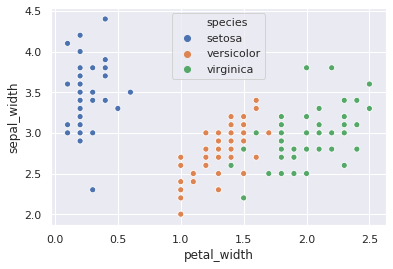

In [74]:
iris_df = sns.load_dataset("iris")
sns.scatterplot(data=iris_df, x="petal_width", y="sepal_width", hue="species")

We have a Iris dataset and we will classify three species of iris flower based on their sepal and petal width.

In [75]:
from sklearn.preprocessing import StandardScaler

X, y = (
    StandardScaler().fit_transform(iris_df[["petal_width", "sepal_width"]]),
    iris_df["species"].astype("category").cat.codes,
)

In [76]:
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC


def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min() - 0.5, x.max() + 0.5
    y_min, y_max = y.min() - 0.5, y.max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, ax, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    levels = list(np.unique(Z) - 0.5) + [Z.max() + 0.5]
    ax = plt if ax is None else ax
    ax.contourf(xx, yy, Z, levels=levels, **params)


def plot_svm(kernel, C, X, y, ax=None):
    svm = SVC(kernel=kernel, C=C)
    svm.fit(X, y)
    is_support = np.isin(np.arange(len(X)), svm.support_)

    xx, yy = make_meshgrid(X[:, 0], X[:, 1])
    plot_contours(svm, xx, yy, colors=sns.color_palette(), ax=ax, alpha=0.5)
    with sns.plotting_context("talk"):
        sns.scatterplot(
            x=X[:, 0],
            y=X[:, 1],
            hue=y,
            style=is_support,
            markers={False: "o", True: "X"},
            palette="muted",
            legend=False,
            ax=ax,
        )
    if ax is not None:
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(f"kernel={kernel}, C={C}")

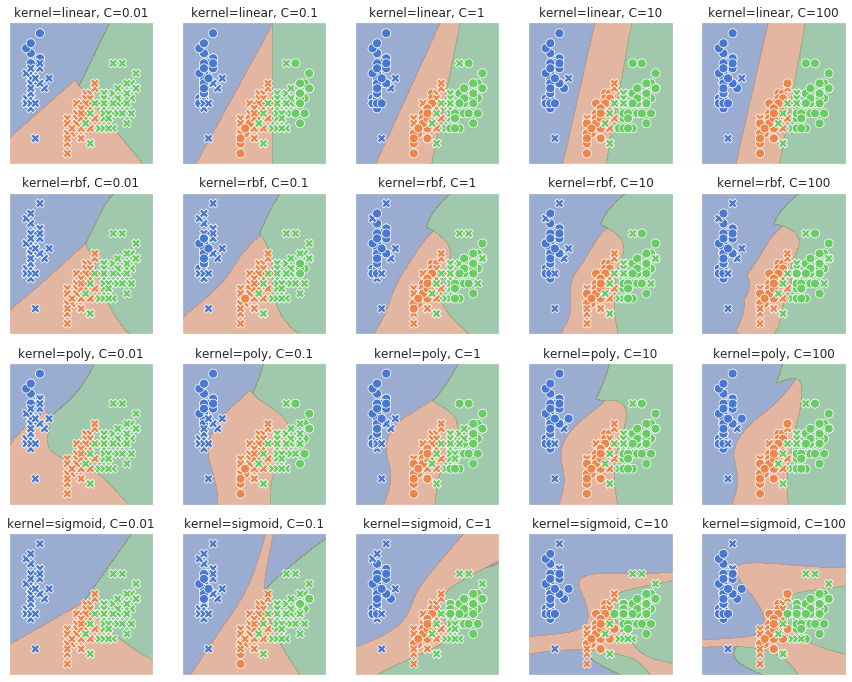

In [77]:
fig, sub = plt.subplots(4, 5, figsize=(15, 12))

for i, kernel in enumerate(("linear", "rbf", "poly", "sigmoid")):
    for j, C in enumerate((0.01, 0.1, 1, 10, 100)):
        plot_svm(kernel, C, X, y, ax=sub[i][j])

In the figure above each color represent different species. The circles and crosses are training instances and crosses are support vectors. The area with the same color is area where point are predicted to be in corresponding class as the area's color.

You can see each kernel's decision boundary a bit different. Linear kernel has strait lines, RBF have nice rounded "bubbles" around each species, polynomial kernel is a bit more pointy and sigmoid kernel is a bit wild of higher `C` values. The bias variance trade-off is very apparent with high bias for 0.01 and very similarly partitioned space and high variance for 100. Notice how a single observation in the bottom left corner is able to shift the decision boundary away from it self for higher `C`.

Let's apply SVM to some real life dataset.

In [78]:
shoppers = pd.read_csv(
    "https://www.fi.muni.cz/~xcechak1/IB031/datasets/online_shoppers_intention.csv"
)
shoppers.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb                 2   
2         0.20       0.20         0.0         0.0   Feb                 4   
3         0.05       0.14         0.0         0.0   Feb                 3   
4         0.02       0.05         0.0         0.0   Feb                 3   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  
2        1       9            3  Returning_Visitor    False    False  
3        2       2            4  Returning_Visitor    False    False  
4        3       1            4  Returning_Visitor     True    False

Here we have a data about online shopping. Each row describes a session of a single user (shopper) and metadata about user. Features range from what other products has the user visited to date to what browser the user was using. The last column is boolean variable whether the user created a revenue for the e-shop, i.e. bought some product.

Some features are categorical and we need to convert them.

In [79]:
for column in ("Month", "Browser", "Region", "TrafficType", "VisitorType"):
    shoppers[column] = shoppers[column].astype("category")
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           12330 non-null  int64   
 1   Administrative_Duration  12330 non-null  float64 
 2   Informational            12330 non-null  int64   
 3   Informational_Duration   12330 non-null  float64 
 4   ProductRelated           12330 non-null  int64   
 5   ProductRelated_Duration  12330 non-null  float64 
 6   BounceRates              12330 non-null  float64 
 7   ExitRates                12330 non-null  float64 
 8   PageValues               12330 non-null  float64 
 9   SpecialDay               12330 non-null  float64 
 10  Month                    12330 non-null  category
 11  OperatingSystems         12330 non-null  int64   
 12  Browser                  12330 non-null  category
 13  Region                   12330 non-null  category
 14  Traffi

In [80]:
shoppers.Revenue.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

The classes are quite imbalanced.

Make a train test split.

In [81]:
shoppers_X, shoppers_y = shoppers.drop(columns="Revenue"), shoppers.Revenue

shoppers_train_X, shoppers_test_X, shoppers_train_y, shoppers_test_y = train_test_split(
    shoppers_X, shoppers_y, test_size=0.2, random_state=42
)

<div class="alert alert-block alert-warning"><b>Exercise 3</b></div>

Use [support vector machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to classify user sessions that lead to buying a product (revenue). Do not forget to **one hot encode categorical** features, **scale the rest** of the features, and set **class_weight** to "balanced" to account for imbalanced classes.

The expected F1 score on test set is $0.92$ for sessions resulting in no revenue and $0.66$ for sessions ending with revenue. 

In [110]:
# TODO: your code goes here...
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

svc_pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(handle_unknown="ignore"), shoppers_X.select_dtypes(include='category').columns),
        (StandardScaler(), shoppers_X.select_dtypes(include=['int64', 'float64']).columns),
        remainder="passthrough",
    ),
    SVC(class_weight='balanced')
)

svc_pipeline.fit(shoppers_train_X, shoppers_train_y)
print(f1_score(svc_pipeline.predict(shoppers_test_X), shoppers_test_y, average=None))

[0.91924528 0.6645768 ]


<div class="alert alert-block alert-warning"><b>Exercise 4</b></div>

Run a grid search with 5-fold CV to tune SVM hyper-parameters. Try different values of `C`, `gamma`, `kernel`, `degree`, or `coef0` and optimize **F1** score. Evaluate the model with best parameters using **F1 score** on test set.

You should see slight increase in F1 score for both classes depending on what values you try. The computation will take a long time so start with only few values for few hyper-parameters.

In [117]:
# TODO: your code goes here...
parameters = {'C':[1], 'gamma':('scale', 'auto'), 'kernel':('rbf', 'poly'), 'degree':[3], 'coef0': [0.0]}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid=parameters, cv=5, scoring='f1')
result = clf.fit(svc_pipeline[0].transform(shoppers_train_X), shoppers_train_y)
print(result.best_params_)
print(result.best_score_)
print(f1_score(result.best_estimator_.predict(svc_pipeline[0].transform(shoppers_test_X)), shoppers_test_y, average=None))

{'C': 1, 'coef0': 0.0, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
0.6469944839053681
[0.92461308 0.67386609]
